In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import pandas as pd

In [2]:
image=cv2.imread('lena.bmp')

In [3]:
img=np.array(image)

### Generating a binary image (threshold at 128)

In [4]:
new_img = np.array([[[ 0 if img[i, j, c] < 128 else 1 for c in range(img.shape[2])] 
                           for j in range(int(img.shape[1]))] 
                           for i in range(int(img.shape[0]))], dtype='uint8')

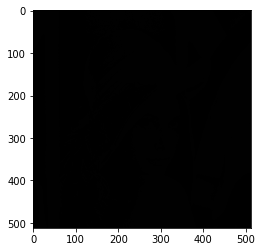

In [160]:
plt.imshow(new_img)

In [70]:
cv2.imwrite('HW2-1.jpg',X)

True

### Generating histogram

In [9]:
hist=np.zeros([266])

In [9]:
hist=np.zeros([256])
for i in range(256):
    hist[i]=i

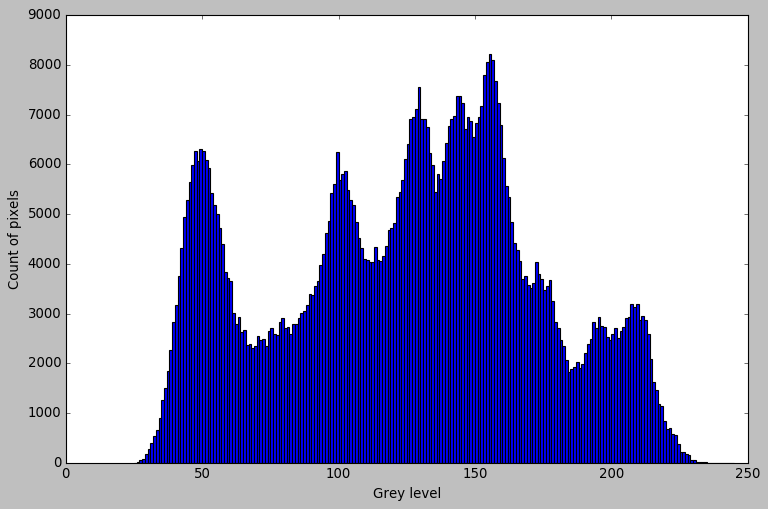

In [63]:
flatten_pixels = np.array([img[r][c][z] for z in range(img.shape[2]) for c in range(img.shape[1]) for r in range(img.shape[0])])
plt.style.use('classic')
fig, ax = plt.subplots(figsize=(11, 7))
ax.hist(flatten_pixels, bins=220)
ax.set_xlabel('Grey level')
ax.set_ylabel('Count of pixels')
plt.savefig('HW2-2.jpg', dpi=300)

### An Efficient Run-Length Implementation of the Local Table Method

In [34]:
def get_perm_table(img_arr):
    # get perm table
    perm_table = np.ones((1, 4) , dtype=np.int16) * -1
    row_record_table = np.ones((img_arr.shape[1], 2), dtype=np.int16) * - 1
    for r in range(img_arr.shape[0]):
        find_c = -1
        for c in range(img_arr.shape[1]):
            if img_arr[r][c][0] > 0 and find_c == -1:
                find_c = c
                if row_record_table[r][0] == -1:
                    row_record_table[r][0] = perm_table.shape[0] - 1
            elif img_arr[r][c][0] == 0 and find_c != -1:
                perm_table = np.vstack([perm_table, np.array([[r, find_c, c, - 1]] , dtype=np.int16)])
                find_c = -1
        if find_c != -1:
            perm_table = np.vstack([perm_table, np.array([[r, find_c, img_arr.shape[1], -1]])])
            
        if row_record_table[r][0] != -1:
            row_record_table[r][1] = perm_table.shape[0] - 1
            
    return perm_table[1:, :], row_record_table

def label_empty_rows(perm_table, new_label, from_row, to_row):
    # label every empty(-1) entries of perm_table
    for i in range(from_row, to_row):
        if perm_table[i][3] == -1:
            perm_table[i][3] = new_label
            new_label += 1
    return new_label

def fill_all_row(perm_table, row_record_table, new_label):
    # fill perm_table's 'label field'
    for i in range(1, row_record_table.shape[0]):
        p_list, q_list = row_record_table[i - 1], row_record_table[i]
        p, q, p_last, q_last = p_list[0], q_list[0], p_list[1], q_list[1]
        while p < p_last and q < q_last:
            p_col_l, p_col_r = perm_table[p][1], perm_table[p][2] - 1
            q_col_l, q_col_r = perm_table[q][1], perm_table[q][2] - 1
            if p_col_l > q_col_r:
                if perm_table[q][3] == -1:
                    perm_table[q][3] = new_label
                    new_label += 1
                q += 1
            elif p_col_r < q_col_l:
                if perm_table[p][3] == -1:
                    perm_table[p][3] = new_label
                    new_label += 1
                p += 1
            else:
                if perm_table[q][3] != -1:
                    if perm_table[p][3] == -1:
                        raise ValueError('Element in p should be labeled first!')
                    assigned_lab = min(perm_table[q][3], perm_table[p][3])
                    for j in range(q):
                        if perm_table[j][3] == perm_table[p][3] or perm_table[j][3] == perm_table[q][3]:
                            perm_table[j][3] = assigned_lab

                    perm_table[q][3], perm_table[p][3] = assigned_lab, assigned_lab
                else:
                    perm_table[q][3] = perm_table[p][3]
                    
                if p_col_r > q_col_r:
                    q += 1
                elif p_col_r < q_col_r:
                    p += 1
                else:
                    q, p = q + 1, p + 1
        
        if p == p_last:
            new_label = label_empty_rows(perm_table, new_label, q ,q_last)
        
        if q == q_last:
            new_label = label_empty_rows(perm_table, new_label, p, p_last)
        
    
    return new_label

def get_connected_components_util(perm_table, new_label):
    # generate connected component dict
    connected_component = dict()
    
    for i, v in enumerate(perm_table):
        if v[3] == -1:
            perm_table[i][3] = new_label
            new_label += 1
        
        if v[3] in connected_component:
            connected_component[v[3]].append(i)
        else:
            connected_component[v[3]] = [i,]
            
    return connected_component
    
def get_connected_components(perm_table, row_record_table):
    new_label = 0
    # assign labels to the first row
    new_label = label_empty_rows(perm_table, new_label, row_record_table[0][0], row_record_table[0][1])
    
    # assign labels to all of the others rows
    new_label = fill_all_row(perm_table, row_record_table, new_label)
    
    # second scanning and get all of the connected components
    connected_component = get_connected_components_util(perm_table, new_label)
    
    return connected_component

def draw_cross(img, pt_row, pt_col):
    # helper function that helps us to draw a cross symbol
    cv2.line(img, (pt_col, pt_row - 4), (pt_col, pt_row + 4), (0, 0, 255), 2)
    cv2.line(img, (pt_col - 4, pt_row), (pt_col + 4, pt_row), (0, 0, 255), 2)
    
def find_centroid(perm_table):
    # find the location of centroid by using a pandas dataframe
    row_top, row_bottom = min([perm_table.iloc[r, 0] for r in range(perm_table.shape[0])]), max([perm_table.iloc[r, 0] for r in range(perm_table.shape[0])])
    row_pix = {r: sum([perm_table[perm_table[0] == r].iloc[i, 2] - 
                       perm_table[perm_table[0] == r].iloc[i, 1] for i in range(perm_table[perm_table[0] == r].shape[0])]) 
               for r in range(row_top, row_bottom + 1)}
    area = sum([r for r in row_pix.values()])
    
    col_leftest, col_rightest = min([perm_table.iloc[r, 1] for r in range(perm_table.shape[0])]), max([perm_table.iloc[r, 2] for r in range(perm_table.shape[0])])
    col_pix = {c: sum([1 if perm_table.iloc[r, 1] <= c < perm_table.iloc[r, 2] else 0 for r in range(perm_table.shape[0])]) for c in range(col_leftest, col_rightest)}
    area_c = sum([c for c in col_pix.values()])
    
    if area_c != area:
        raise ValueError('Some error occured while the program was calculating area!')
    
    row_centroid = sum([i * r for i, r in row_pix.items()]) / area
    col_centroid = sum([i * c for i, c in col_pix.items()]) / area
    return row_centroid, col_centroid

def output_final_result(img, file_name):
    # the main function
    new_img = img.copy()
    perm_table, row_record_table = get_perm_table(new_img)
    connected_component = get_connected_components(perm_table, row_record_table)
    perm_df = pd.DataFrame(perm_table)
    for label, comp_ptr in connected_component.items():
        count_pix = sum([perm_table[c][2] - perm_table[c][1] for c in comp_ptr])
        if count_pix >= 500:
            row_ind = [perm_table[c][0] for c in comp_ptr]
            col_left_ind, col_right_ind = [perm_table[c][1] for c in comp_ptr], [perm_table[c][2] for c in comp_ptr]
            print('find a connected component, bounding box: ', (min(row_ind), max(row_ind), min(col_left_ind), max(col_right_ind)))
            cv2.rectangle(new_img, ( min(col_left_ind), min(row_ind), ), (max(col_right_ind) - 1, max(row_ind), ), (0, 200, 0), 2)
            r_c, c_c = find_centroid(perm_df[perm_df[3] == label])
            draw_cross(new_img, int(r_c), int(c_c))
            print('centroid is located at', (r_c, c_c))
    cv2.imwrite(file_name, new_img)

In [66]:
output_final_result(X,'HW2-3.jpg')

find a connected component, bounding box:  (0, 511, 0, 88)
centroid is located at (229.3128744145518, 42.09835529898704)
find a connected component, bounding box:  (0, 511, 127, 512)
centroid is located at (245.19044745155358, 344.0809373379226)
find a connected component, bounding box:  (94, 237, 118, 158)
centroid is located at (175.49951171875, 132.32373046875)
find a connected component, bounding box:  (237, 287, 89, 140)
centroid is located at (264.0947204968944, 116.62732919254658)
find a connected component, bounding box:  (399, 511, 0, 32)
centroid is located at (457.58187919463086, 17.511409395973153)


In [5]:
class Disjoint:

    def __init__(self):
        self.dic = {}
        
    def __del__(self):
        pass
    
    def add(self, near_set):
        near_set.sort()
        find_re=self.find(near_set[0])
        if(find_re==False):
            self.dic[near_set[0]]=-1
        if len(near_set)>1:
            for i in range(1,len(near_set)):
                if self.find(near_set[i])<=0 or self.find(near_set[i])==near_set[i]:
                    self.dic[near_set[i]]=near_set[0]
                
    def find(self, n):
        tmp=n
        while(tmp!=-1):
            tmp2=self.dic.get(tmp)
            if(tmp2==None):
                return False
            if(tmp2==-1):
                return tmp
            tmp=tmp2
        return n
    
    def revolve(self):
        min_dic={}
        result={}
        for i in self.dic:
            tmp=self.find(self.dic[i])
            if tmp==-1:
                if min_dic.get(i)==None:
                    min_dic[i]=[i]
                else:
                    min_dic[i].append(i)
            else:
                if min_dic.get(tmp)==None:
                    min_dic[tmp]=[i]
                else:
                    min_dic[tmp].append(i)
        
        new_max_label=0
        for i in min_dic:
            min_v=min(min_dic[i])
            if(min_v>new_max_label):
                new_max_label=min_v
            for j in min_dic[i]:
                result[j]=min_v
        return result, new_max_label            
                
    def clear(self):
        for i in self.dic:
            if(self.dic[i]!=-1):
                self.dic.pop(i)
        

In [179]:
test=Disjoint()

In [180]:
test.add([2,3,6])

In [181]:
test.add([2,4,5,1])

In [235]:
test.add([33])

In [236]:
test.dic

{2: 1, 3: 2, 6: 2, 1: -1, 4: 1, 5: 1, 9: 4, 33: -1}

In [237]:
a,b=test.revolve()

In [238]:
a

{2: 1, 3: 1, 6: 1, 1: 1, 4: 1, 5: 1, 9: 1, 33: 33}

In [121]:
con={}
for i in test.dic:
    tmp=test.find(test.dic[i])
    if tmp==-1:
        if con.get(i)==None:
            con[i]=[i]
        else:
            con[i].append(i)
    else:
        if con.get(tmp)==None:
            con[tmp]=[i]
        else:
            con[tmp].append(i)

In [122]:
con

{1: [2, 3, 6, 1, 4, 5]}

In [6]:
class neighbor:
    def __init__(self): 
        pass
    def um(self,l,p):
        return (l-1,p)
    def ul(self,l,p):
        return (l-1,p-1)
    def ur(self,l,p):
        return (l-1,p+1)
    def rm(self,l,p):
        return (l,p+1)
    def lm(self,l,p):
        return (l,p-1)
    def dm(self,l,p):
        return (l+1,p)
    def dl(self,l,p):
        return (l+1,p-1)
    def dr(self,l,p):    
        return (l+1,p+1) 

In [19]:
L_len=new_img.shape[0]
P_len=new_img.shape[1]

label_img=np.zeros((L_len,P_len))
c=0
label=0
cal=neighbor()

if new_img[0][0][c]==1:
    label=label+1
    label_img[0][0]=label

#first row
for p in range(P_len):
    
    if new_img[0][p][c]==1:
        if(label_img[cal.lm(0,p)])>0:
            label_img[1][p]=label_img[cal.lm(0,p)]

        else:
            label=label+1
            label_img[0][p]=label
            
for l in range(1,L_len):
    eqtable=Disjoint()
    #first element every line
    if new_img[l][0][c]==1:
        if(label_img[cal.um(l,0)])>0:
            label_img[l][0]=label_img[cal.um(l,0)]
            eqtable.add([label_img[cal.um(l,0)]])
        else:
            label=label+1
            label_img[l][0]=label
            eqtable.add([label])
    for p in range(1,P_len):
        if new_img[l][p][c]==1:
            near=[]
            for i in [cal.lm(l,p), cal.um(l,p), cal.ul(l,p)]:
                if label_img[i]>0:
                    near.append(label_img[i])
            if len(near)==0:
                label=label+1
                label_img[l][p]=label
                eqtable.add([label])
            else:
                near=list(set(near))
                label_img[l][p]=near[0]
                eqtable.add(near)
    
    min_label_dic,label=eqtable.revolve()
    del eqtable
    for p in range(0,P_len):
        if new_img[l][p][c]==1:
            label_img[l][p]=min_label_dic[(label_img[l][p])]

for l in range(L_len-2,-1,-1):
    eqtable=Disjoint()
#first element every line
    if label_img[l][0]>0:
        if(label_img[cal.dm(l,0)])>0:
            eqtable.add([label_img[cal.dm(l,0)],label_img[l][0]])
 
    for p in range(1,P_len):
        if label_img[l][p]>0:
            near=[label_img[l][p]]
            for i in [cal.lm(l,p),cal.dm(l,p),cal.dl(l,p)]:
                if label_img[i]>0:
                    near.append(label_img[i])
                if len(near)>0:
                    near=list(set(near))
                    eqtable.add(near)
    min_label_dic,label=eqtable.revolve()
    del eqtable
    for p in range(0,P_len):
        if label_img[l][p]>0:
            label_img[l][p]=min_label_dic[(label_img[l][p])]              


KeyboardInterrupt: 

In [ ]:
for i in range(label_img.shape[0]):
    for j in range(label_img.shape[1]):
        if(label_img[i][j]>0):
            print(label_img[i][j],end="")
        else:
            print(" ",end="")
    print("")

2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 12.0 13.0 14.0 15.0 16.0 17.0 18.0 19.0 20.0 21.0 22.0 23.0 24.0 25.0 26.0 27.0 28.0 29.0 30.0 31.0 32.0                                                            33.0    34.0 35.0 36.0 37.0 38.0 39.0 40.0 41.0 42.0 43.0 44.0 45.0 46.0 47.0 48.0 49.0 50.0 51.0 52.0 53.0 54.0 55.0 56.0 57.0 58.0 59.0 60.0 61.0 62.0 63.0 64.0 65.0 66.0 67.0 68.0 69.0 70.0 71.0 72.0 73.0 74.0 75.0 76.0 77.0 78.0 79.0 80.0 81.0 82.0 83.0 84.0 85.0 86.0 87.0 88.0 89.0 90.0 91.0 92.0 93.0 94.0 95.0 96.0 97.0 98.0 99.0 100.0 101.0 102.0 103.0 104.0 105.0 106.0 107.0 108.0  109.0 110.0   111.0 112.0   113.0 114.0  115.0  116.0   117.0 118.0                     119.0 120.0 121.0 122.0 123.0 124.0 125.0 126.0 127.0 128.0 129.0 130.0 131.0 132.0 133.0 134.0 135.0 136.0 137.0 138.0 139.0 140.0 141.0 142.0 143.0 144.0 145.0 146.0 147.0 148.0 149.0 150.0 151.0 152.0 153.0 154.0 155.0 156.0 157.0 158.0 159.0 160.0 161.0 162.0 163.0 164.0 165.0 166.0 167.0                    

In [ ]:
a=np.zeros((3,4))

In [240]:
x=np.where(label_img==33.0)

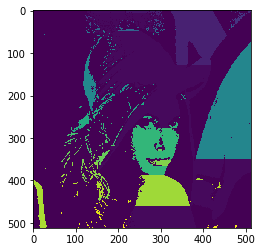

In [18]:
plt.imshow(label_img)

In [ ]:
#first cell of the last line
#eqtable=Disjoint()
#if label_img[L_len-1][0]>0:
#    near=[]
#    for i in [cal.um(L_len-1,0),cal.rm(L_len-1,0),cal.ur(L_len-1,0)]:
#        if label_img[i]>0:
#            near.append(label_img[i])
#        if len(near)>0:
#            near=list(set(near))
#            eqtable.add(near)
#The last line

#for p in range(1,P_len):
#    if label_img[L_len-1][p]>0:
#        near=[]
#        for i in [cal.lm(L_len-1,p)]:
#            if label_img[i]>0:
#                near.append(label_img[i])
#            if len(near)>0:
#                near=list(set(near))
#                eqtable.add(near)
#last cell of the last line
#if label_img[L_len-1][P_len-1]>0:
#    near=[]
#    for i in [cal.um(L_len-1,P_len-1),cal.lm(L_len-1,P_len-1),cal.ul(L_len-1,P_len-1)]:
#        if label_img[i]>0:
#            near.append(label_img[i])
#        if len(near)>0:
#            near=list(set(near))
#            eqtable.add(near)
"""
for l in range(L_len-2,-1,-1):
    eqtable=Disjoint()
#first element every line
    if label_img[l][0]>0:
        if(label_img[cal.dm(l,0)])>0:
            eqtable.add([label_img[cal.dm(l,0)],label_img[l][0]])
 
    for p in range(1,P_len):
        if label_img[l][p]>0:
            near=[label_img[l][p]]
            for i in [cal.lm(l,p),cal.dm(l,p),cal.dl(l,p)]:
                if label_img[i]>0:
                    near.append(label_img[i])
                if len(near)>0:
                    near=list(set(near))
                    eqtable.add(near)
    min_label_dic,label=eqtable.revolve()
    del eqtable
    for p in range(0,P_len):
        if label_img[l][p]>0:
            label_img[l][p]=min_label_dic[(label_img[l][p])]  
"""